# Install Libraries

In [1]:
!pip install pillow

# Download Dataset

In [2]:
DATASET_FILE = "scalene_triangle_0_355_step5_randomtest.zip"
DATASET_DIR = "scalene_triangle_0_355_step5_randomtest"
!rm -rf "$DATASET_DIR"
!curl -L https://github.com/joshbarrass/Y4ProjectNotebooks/raw/master/$DATASET_FILE > "$DATASET_FILE"
!unzip -d "$DATASET_DIR" "$DATASET_FILE" > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   181  100   181    0     0   1946      0 --:--:-- --:--:-- --:--:--  1967
100  339k  100  339k    0     0  1952k      0 --:--:-- --:--:-- --:--:-- 1952k


# Define Helper Functions

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from scipy.spatial.transform import Rotation as R

D6_SHAPE = (3, 2)

def normalise(x):
    return x / np.linalg.norm(x)

def from_SO3_to_6D(SO3):
    """Convert an SO(3) rotation matrix to a 6D internal representation."""
    return SO3[:,:2]

def from_6D_to_SO3(D6):
    """Convert a 6D internal representation to an SO(3) rotation matrix."""
    b1 = normalise(D6[:,0])
    b2 = normalise(D6[:,1] - np.dot(b1, D6[:,1])*b1)
    b3 = np.cross(b1, b2)
    return np.array([b1, b2, b3]).T

def tf_6D_to_SO3(D6):
  """tensorflow-compatible conversion from 6D to SO(3). Used in the D6Convert layer."""
  a1 = D6[:,:,0]
  a2 = D6[:,:,1]
  b1 = tf.math.l2_normalize(a1, axis=-1)
  b2 = tf.math.l2_normalize(a2 - tf.reduce_sum(b1*a2)*b1, axis=-1)
  b3 = tf.linalg.cross(b1, b2)
  return tf.stack([b1, b2, b3], axis=2)

class D6Convert(layers.Layer):
  def call(self, inputs):
    target_input_shape = tf.TensorShape(((None,) + D6_SHAPE))
    if not inputs.shape.is_compatible_with(target_input_shape):
      raise TypeError("inputs to D6Convert should have shape {}, not {}".format(target_input_shape, inputs.shape))
    return tf_6D_to_SO3(inputs)

### DEPRECATED: Returns wrong value
# def SO3_distance(M1, M2):
#  """Returns the distance between two SO3 matrices in degrees"""
#  R = M1 * np.linalg.inv(M2)
#  return np.rad2deg(np.arccos((np.trace(R)-1)/2))

# Implement Quaternion SO(3) Distance

In [4]:
# quaternion [x, y, z, w]: w + xi + yj + zk
# this is the format outputted by scipy
def SO3_distance(M1, M2):
  """Returns the angle between two SO3 matrices in degrees.

  This is done by converting the matrices to quaternions and multiplying the
  conjugate of one with the other. The scalar part of the resulting quaternion
  is then cos(theta/2). The expression has been simplified to calculate only the
  scalar part."""
  x1, y1, z1, w1 = R.from_matrix(M1).as_quat()
  x2, y2, z2, w2 = R.from_matrix(M2).as_quat()
  return np.rad2deg(2*np.arccos(w1*w2 + x1*x2 + y1*y2 + z1*z2))

### TEST SO3_distance
test_tolerance = 0.001
for i in range(100):
  test_angle1, test_angle2 = np.random.uniform(0, 180, 2) # max difference should be 180, as > 180 is no longer the shortest angle
  testM1 = R.from_euler("zyx", [test_angle1, 0, 0], degrees=True).as_matrix()
  testM2 = R.from_euler("zyx", [test_angle2, 0, 0], degrees=True).as_matrix()
  test_true_angle = abs(test_angle1-test_angle2)
  test_angle = abs(SO3_distance(testM1, testM2))
  assert test_angle + test_tolerance > test_true_angle and test_angle - test_tolerance < test_true_angle

In [5]:
SO31 = R.from_euler("zyx",[3, 2, 1]).as_matrix()
D61 = from_SO3_to_6D(SO31)
SO32 = R.from_euler("zyx",[0.5, 1, 1.2]).as_matrix()
D62 = from_SO3_to_6D(SO32)
print("True:", SO31, "\n", SO32, sep="")
print("np1:", from_6D_to_SO3(D61))
print("np2:", from_6D_to_SO3(D62))
print("tf:", tf_6D_to_SO3(np.array([D61, D62])))

True:[[ 0.41198225  0.05872664  0.90929743]
 [-0.68124272 -0.64287284  0.35017549]
 [ 0.60512725 -0.76371834 -0.2248451 ]]
[[ 0.47415988 -0.25903472  0.84147098]
 [ 0.86199739 -0.05800686 -0.50358287]
 [ 0.17925654  0.96412459  0.19578273]]
np1: [[ 0.41198225  0.05872664  0.90929743]
 [-0.68124272 -0.64287284  0.35017549]
 [ 0.60512725 -0.76371834 -0.2248451 ]]
np2: [[ 0.47415988 -0.25903472  0.84147098]
 [ 0.86199739 -0.05800686 -0.50358287]
 [ 0.17925654  0.96412459  0.19578273]]
tf: tf.Tensor(
[[[ 0.41198225  0.05872664  0.90929743]
  [-0.68124272 -0.64287284  0.35017549]
  [ 0.60512725 -0.76371834 -0.2248451 ]]

 [[ 0.47415988 -0.25903472  0.84147098]
  [ 0.86199739 -0.05800686 -0.50358287]
  [ 0.17925654  0.96412459  0.19578273]]], shape=(2, 3, 3), dtype=float64)


# Load and Pre-Process Training Data

Dataset contains 72 images
Image shape is (50, 50, 1)
x will have shape (72, 50, 50, 1)
y will have shape (72, 3, 3)
Processing image files...


  0%|          | 0/72 [00:00<?, ?it/s]

Loading test data...


  0%|          | 0/14 [00:00<?, ?it/s]

x_data has shape (72, 50, 50, 1)
y_data has shape (72, 3, 3)
x_test has shape (14, 50, 50, 1)
y_test has shape (14, 3, 3)
x_data values range from 0.0 to 1.0


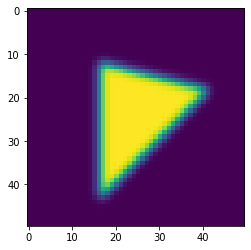

[[ 2.220446e-16 -1.000000e+00  0.000000e+00]
 [ 1.000000e+00  2.220446e-16  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]]


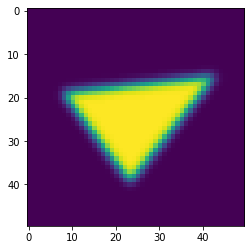

[[ 0.62741959  0.77868136  0.        ]
 [-0.77868136  0.62741959  0.        ]
 [ 0.          0.          1.        ]]


In [6]:
import os
import random
import numpy as np
from scipy.spatial.transform import Rotation as R
from PIL import Image, ImageFilter
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

random.seed(0)

RESIZE_SHAPE = (50, 50)

GAUSS_RADIUS = 1
image_filter = ImageFilter.GaussianBlur(radius=GAUSS_RADIUS)

image_files = os.listdir(os.path.join(DATASET_DIR, "train"))
total_images = len(image_files)
print(f"Dataset contains {total_images} images")
if total_images == 0:
  raise ValueError("dataset has no images")

# image_shape = Image.open(os.path.join(DATASET_DIR, image_files[0])).size
image_shape = RESIZE_SHAPE + (1,)
print(f"Image shape is {image_shape}")
x_data = np.zeros((total_images,) + image_shape, dtype="float32")
y_data = np.zeros((total_images, 3, 3), dtype="float32")
print(f"x will have shape {x_data.shape}")
print(f"y will have shape {y_data.shape}")
print("Processing image files...")

def process_image(imf):
  """Takes a path to an image and loads it, performs pre-processing, and returns the xdata and ydata"""
  im = Image.open(imf).convert("L")
  im = im.resize(RESIZE_SHAPE)
  im = im.filter(image_filter)
  angle = float(os.path.splitext(os.path.basename(imf))[0])
  return np.array(im).reshape(image_shape)/255., R.from_euler("zyx", (angle, 0, 0), True).as_matrix()

# load training data
for i, imf in tqdm(enumerate(image_files), total=total_images):
  x_data[i,:,:], y_data[i,:,:] = process_image(os.path.join(DATASET_DIR, "train", imf))

test_image_files = os.listdir(os.path.join(DATASET_DIR, "test"))
total_test_images = len(test_image_files)
x_test = np.zeros((total_test_images,) + x_data.shape[1:])
y_test = np.zeros((total_test_images,) + y_data.shape[1:])
print("Loading test data...")
for i, imf in tqdm(enumerate(test_image_files), total=total_test_images):
  x_test[i,:,:], y_test[i,:,:] = process_image(os.path.join(DATASET_DIR, "test", imf))

print(f"x_data has shape {x_data.shape}")
print(f"y_data has shape {y_data.shape}")
print(f"x_test has shape {x_test.shape}")
print(f"y_test has shape {y_test.shape}")

print(f"x_data values range from {np.min(x_data)} to {np.max(x_data)}")

plt.imshow(x_data[0,:,:].reshape(RESIZE_SHAPE))
plt.show()
print(y_data[0,:,:])
plt.imshow(x_test[1,:,:].reshape(RESIZE_SHAPE))
plt.show()
print(y_test[1,:,:])

# Construct Network

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

batch_size = 5
epochs = 200

model = keras.Sequential([
                          layers.InputLayer(input_shape=image_shape),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPool2D(pool_size=2, strides=2),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPool2D(pool_size=2, strides=2),
                          layers.Flatten(),
                          layers.Dense(64, activation="relu"),
                          layers.Dense(128, activation="relu"),
                          layers.Dense(256, activation="relu"),
                          layers.Dense(128, activation="relu"),
                          layers.Dense(64, activation="relu"),
                          layers.Dense(np.prod(D6_SHAPE), activation="tanh"),
                          layers.Reshape(D6_SHAPE),
                          D6Convert(),
])
model.summary()
model.compile(optimizer="sgd", loss="mean_squared_error", metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3872)              0         
                                                                 
 dense (Dense)               (None, 64)                2

# Train Model

Epoch 1/200
15/15 [==============================] - 1s 38ms/step - loss: 0.5110 - accuracy: 0.4444 - val_loss: 0.6389 - val_accuracy: 0.1667
Epoch 2/200
15/15 [==============================] - 0s 20ms/step - loss: 0.4660 - accuracy: 0.5139 - val_loss: 0.4759 - val_accuracy: 0.5714
Epoch 3/200
15/15 [==============================] - 0s 20ms/step - loss: 0.4428 - accuracy: 0.5833 - val_loss: 0.5936 - val_accuracy: 0.5000
Epoch 4/200
15/15 [==============================] - 0s 20ms/step - loss: 0.4427 - accuracy: 0.6019 - val_loss: 0.6152 - val_accuracy: 0.5000
Epoch 5/200
15/15 [==============================] - 0s 20ms/step - loss: 0.4613 - accuracy: 0.5694 - val_loss: 0.5926 - val_accuracy: 0.5000
Epoch 6/200
15/15 [==============================] - 0s 21ms/step - loss: 0.4545 - accuracy: 0.5880 - val_loss: 0.6105 - val_accuracy: 0.5000
Epoch 7/200
15/15 [==============================] - 0s 20ms/step - loss: 0.4321 - accuracy: 0.5833 - val_loss: 0.4840 - val_accuracy: 0.5714
Epoch 

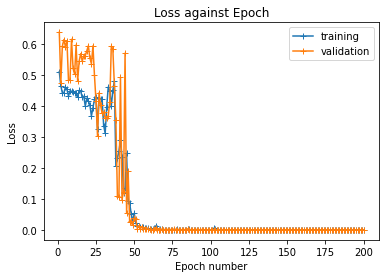

In [8]:
history = model.fit(
    x_data,
    y_data,
    batch_size,
    epochs,
    validation_data=(x_test, y_test),
)
plt.plot([i for i in range(1, len(history.history["loss"])+1)], history.history["loss"], "+-", label="training")
plt.plot([i for i in range(1, len(history.history["val_loss"])+1)], history.history["val_loss"], "+-", label="validation")
plt.legend()
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.title("Loss against Epoch")
plt.show()

# Test Model

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 5.8325062127551064e-05
Test accuracy: 1.0


In [10]:
i = 6
print("True SO(3):\n", y_test[i].astype("float32"), end="\n\n", sep="")
prediction = model.predict(x_test[i].reshape((1,)+x_test[i].shape))[0]
print("SO(3) Prediction:\n", prediction, sep="")
print("Distance: {:.2f} degrees".format(SO3_distance(y_test[i], prediction)))

True SO(3):
[[-0.76300687  0.6463904   0.        ]
 [-0.6463904  -0.76300687  0.        ]
 [ 0.          0.          1.        ]]

SO(3) Prediction:
[[-7.6592940e-01  6.4292294e-01  1.4903118e-03]
 [-6.4292461e-01 -7.6592761e-01 -1.6697187e-03]
 [ 6.7970628e-05 -2.2370450e-03  9.9999750e-01]]
Distance: 0.29 degrees


# Analyse Results

  0%|          | 0/14 [00:00<?, ?it/s]

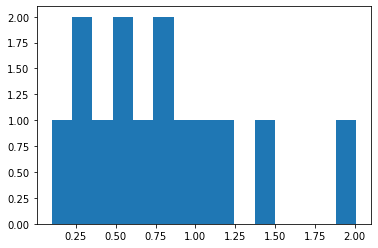

In [11]:
distances = np.zeros(x_test.shape[0])
for i in tqdm(range(x_test.shape[0])):
  prediction = model.predict(x_test[i].reshape((1,)+x_test[i].shape))[0]
  distances[i] = SO3_distance(y_test[i], prediction)

plt.hist(distances, bins=15)
plt.show()

In [12]:
distance_mean = np.mean(distances)
distance_std = np.std(distances, ddof=1)
print(f"Average distance from the true value is {distance_mean:.2f} +- {distance_std:.2f}")

Average distance from the true value is 0.79 +- 0.50
